# Домашнее задание 1

В этом домашнем задании мы немного поупражняемся с обработкой временных данных и базовыми моделями.

В приложенном файле находится всего один временной ряд. Он представляет из себя срезы некоторых значений, связанных с движениями ликвидности одного крупного российского банка. Требуется построить модель, способную прогнозировать суммарное значение этого ряда за день.

#### Описание бизнес-процесса, связанного с рядом.

Ликвидностью обычно называют высоколиквидные активы, т.е. активы, которые легко купить и продать, чтобы быстро конвертировать в деньги. Собственно, сами по себе деньги это тоже ликвидность. Но ими также могут быть ценные бумаги крупных компаний и деривативы на них. Для банков важно поддерживать некоторый уровень ликвидности, чтобы всегда иметь возможность либо быстро отдать краткосрочные долги. Крупнейшие банковские кризисы во многом состоялись из-за набега вкладчиков, забравших свои деньги, из-за чего банки не могли в моменте обслуживать свои займы. Ликвидные активы можно быстро вложить, если на рынке встретились хорошие условия. Если ликвидности избыток, её можно вложить, а если недостаток -- занять.

Мы хотим прогнозировать сумму (сальдо) поступлений и списаний за день. На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке для получения дополнительной прибыли. В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ (дать в долг) по overnight ставке, равной ключевой-0.9%. В случае, если на конец дня образуется дефицит ликвидности (опасность не вернуть долги), его можно покрыть за счет займа по overnight ставке, равной ключевая+1%.


In [424]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')
import datetime

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

## 1) Загрузка данных (0.5 балла)

Загрузите временной ряд. Преобразуйте даты во временных данных. Вам необходимо определить частоту данных, так как от этого будут зависеть параметры модели. Исходя из частоты выберите оффсет [Оффсет](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects).Не спешите отвечать на этот вопрос и посмотрите на данные **внимательно**. Сделайте ресэмпл ряда к выбранному оффсету. Если вы всё сделали правильно, то дисперсия ряда должна быть примерно одинаковой на любом участке.

In [443]:
data = pd.read_csv("https://raw.githubusercontent.com/Pyatachokk/hse_ts_course/master/2024-spring/homeworks/hw1/data.csv")
day_exclusion = ['Saturday', 'Sunday']
data['Date'] = pd.to_datetime(data['Date'])
data = data[~(data['Date'].dt.hour == 9)]
# data = data[~(data['Date'].dt.day_name().isin(day_exclusion))]
data.set_index('Date', inplace=True)
df = data.resample('D').mean()
df = df[~(df.index.day_name().isin(day_exclusion))]
df=df[df.Target!=0] #иначе будут проблемы при вычислении wape
df.head()

,Target
Date,
2017-01-09,-0.082742
2017-01-10,-0.154609
2017-01-11,-0.216529
2017-01-12,-0.231265
2017-01-13,-0.207156


У меня стойкое ощущение, что я всё дз сделала неверно, начиная с первого задания))) Был выбран оффсет D, так как как нам нужно прогнозировать посуточное сальдо поступлений/списаний (соответственно, брать ресемпл по более редкому обновлению данных бессмысленно). Первые почти 2.5 года данные обновляются каждые два часа, а с сентября 2019 просто раз в сутки - придумать, как за такой длительный период с 19 по 20 годы включительно обновлялись несколько раз в сутки данные я не знаю и вряд ли это хотя бы приблизительно верно будет (и даже близко равную дисперсию не получилось бы наблюдать при более частом обновлении, чем раз в сутки, но и тут не очень все хорошо). Итог: делала ресемпл датасета по D только по будням, тк по выходным значения таргета равны всегда 0 (и в 9 утра в будни тоже, поэтому удалила эти объекты, они портили качество модели). В общем я запуталась

## 2) Визуальный анализ (0.5 балла)

Изобразите временной ряд, его автокорреляции и частные автокорреляции до порядка, который сочтёте нужным.

Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Стационарность? Как эти особенности могут помочь прогнозировать?  Ответьте на **каждый** вопрос.

Хинт: если построить коррелограммы на приращениях ряда, а не на исходных величинах, то некоторые паттерны видны лучше.


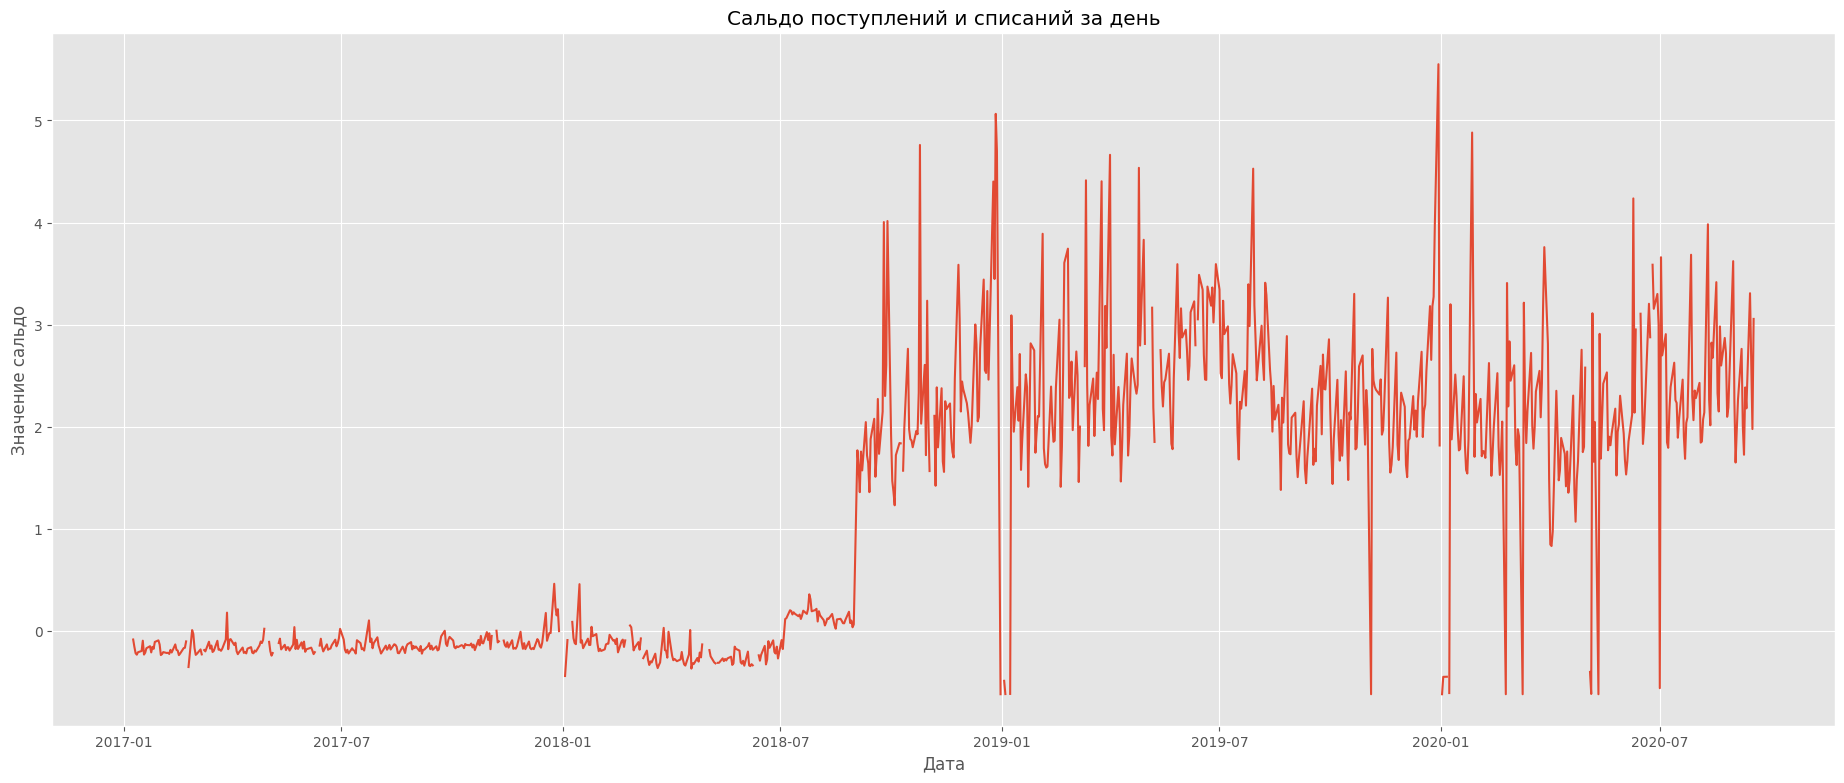

In [444]:
plt.plot(df.index, df['Target'])
plt.title('Сальдо поступлений и списаний за день')
plt.xlabel('Дата')
plt.ylabel('Значение сальдо')
plt.show();

<Figure size 1200x600 with 0 Axes>

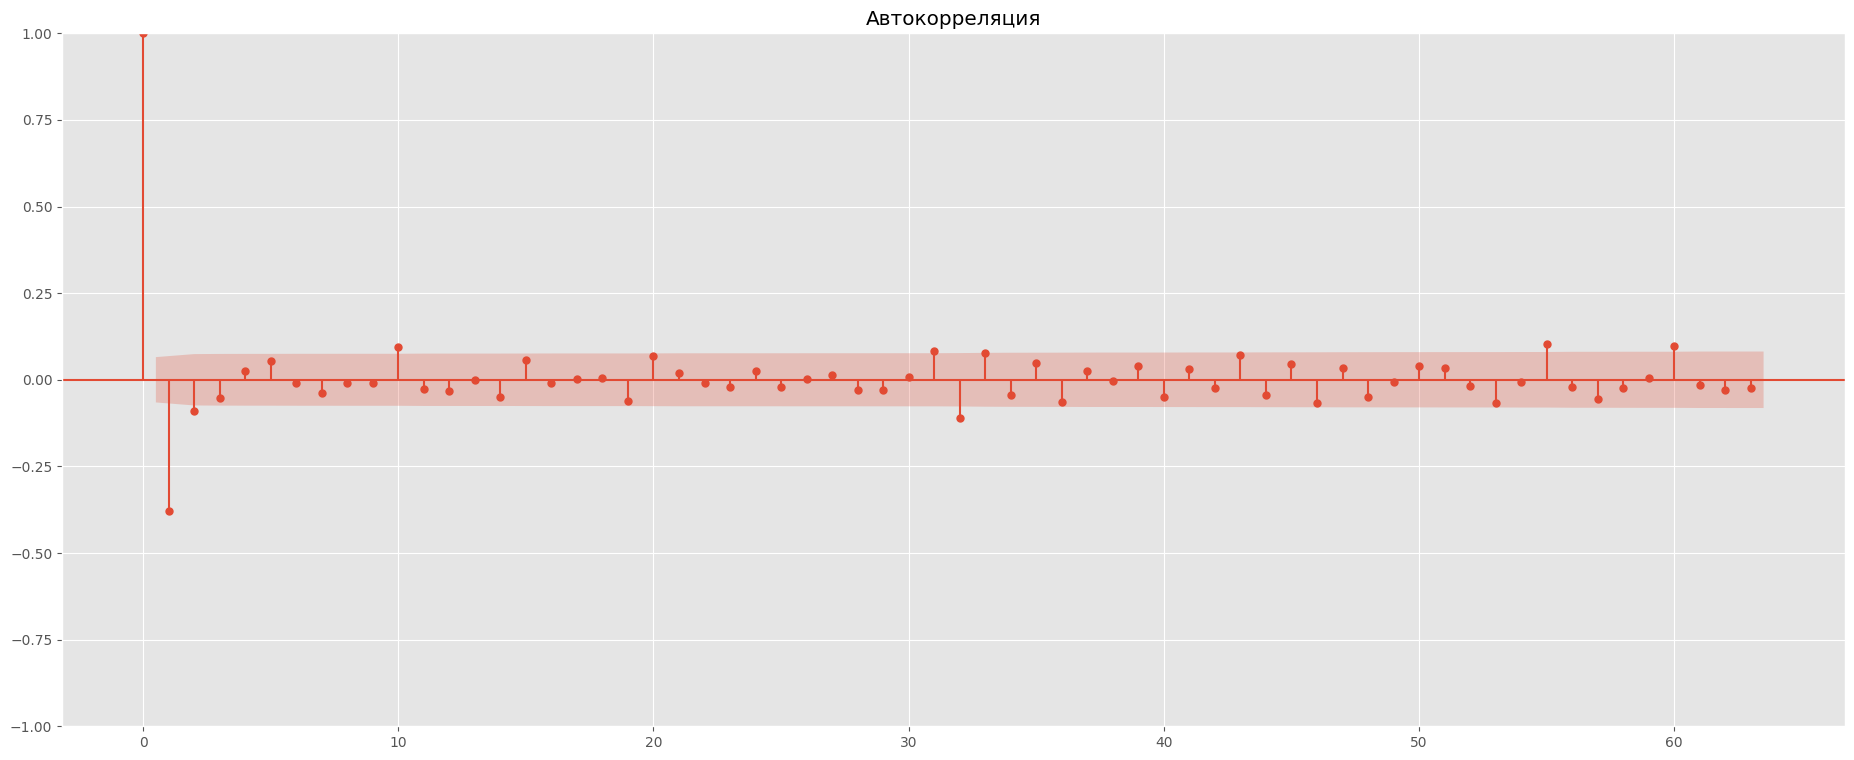

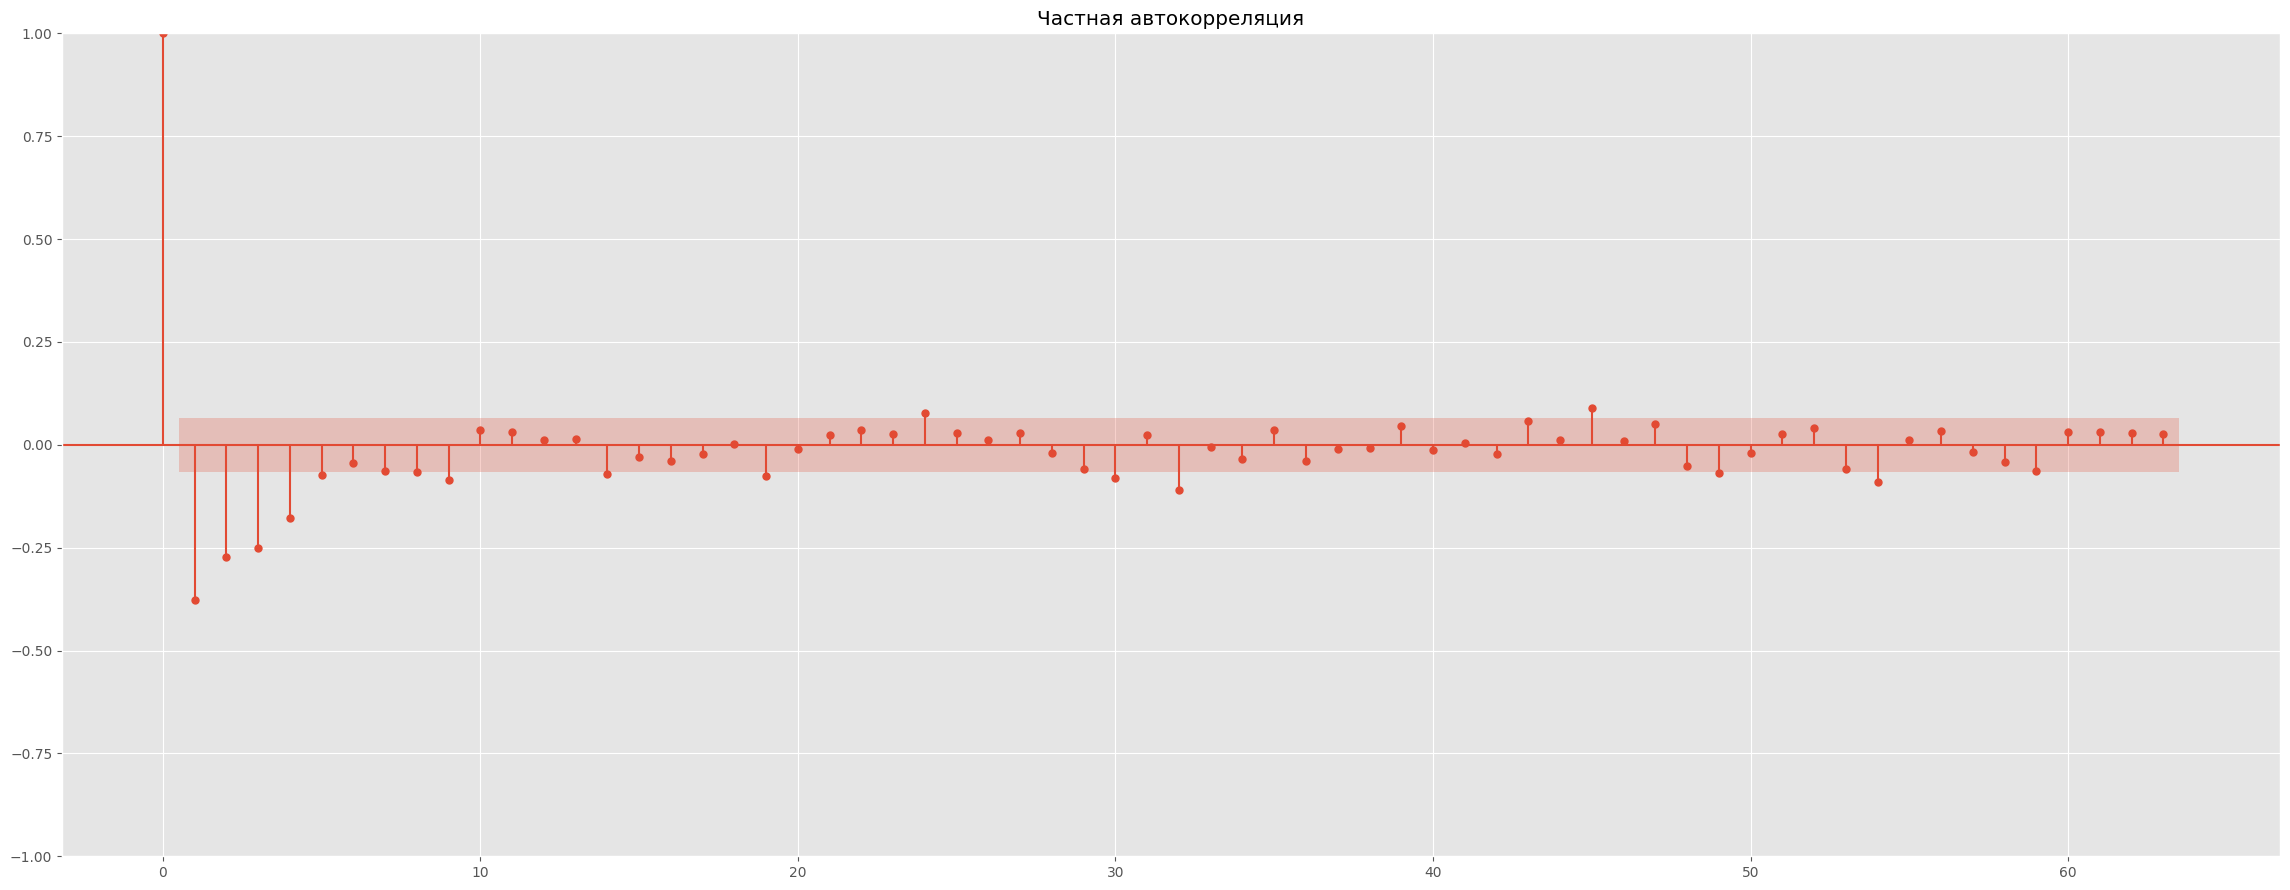

In [445]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['Target'].diff().dropna(), lags=63, title='Автокорреляция')
sm.graphics.tsa.plot_pacf(df['Target'].diff().dropna(), lags=63, title='Частная автокорреляция')
plt.tight_layout()
plt.show();

Сложно проанализировать графики, так как в середине временного ряда есть структурный скачок. В данных присутствует сезонность (например, колебания на начало года повторяют друг друга). Если брать ряд цельно, то, конечно, он не является стационарным, так как заметно меняется и матожидание, и дисперсия в середине. Если рассматривать по отдельности каждую половину, то можно сказать, что эти части являются стационарными. Опять же в сентябре 2019 года тренд (угол)сменяется. Цикличность присутствует, это можно увидеть, например, на графике частной автокорреляции и полной автокорреляции: присутствуют пики каждые 30-32 дней (то есть каждый месяц).

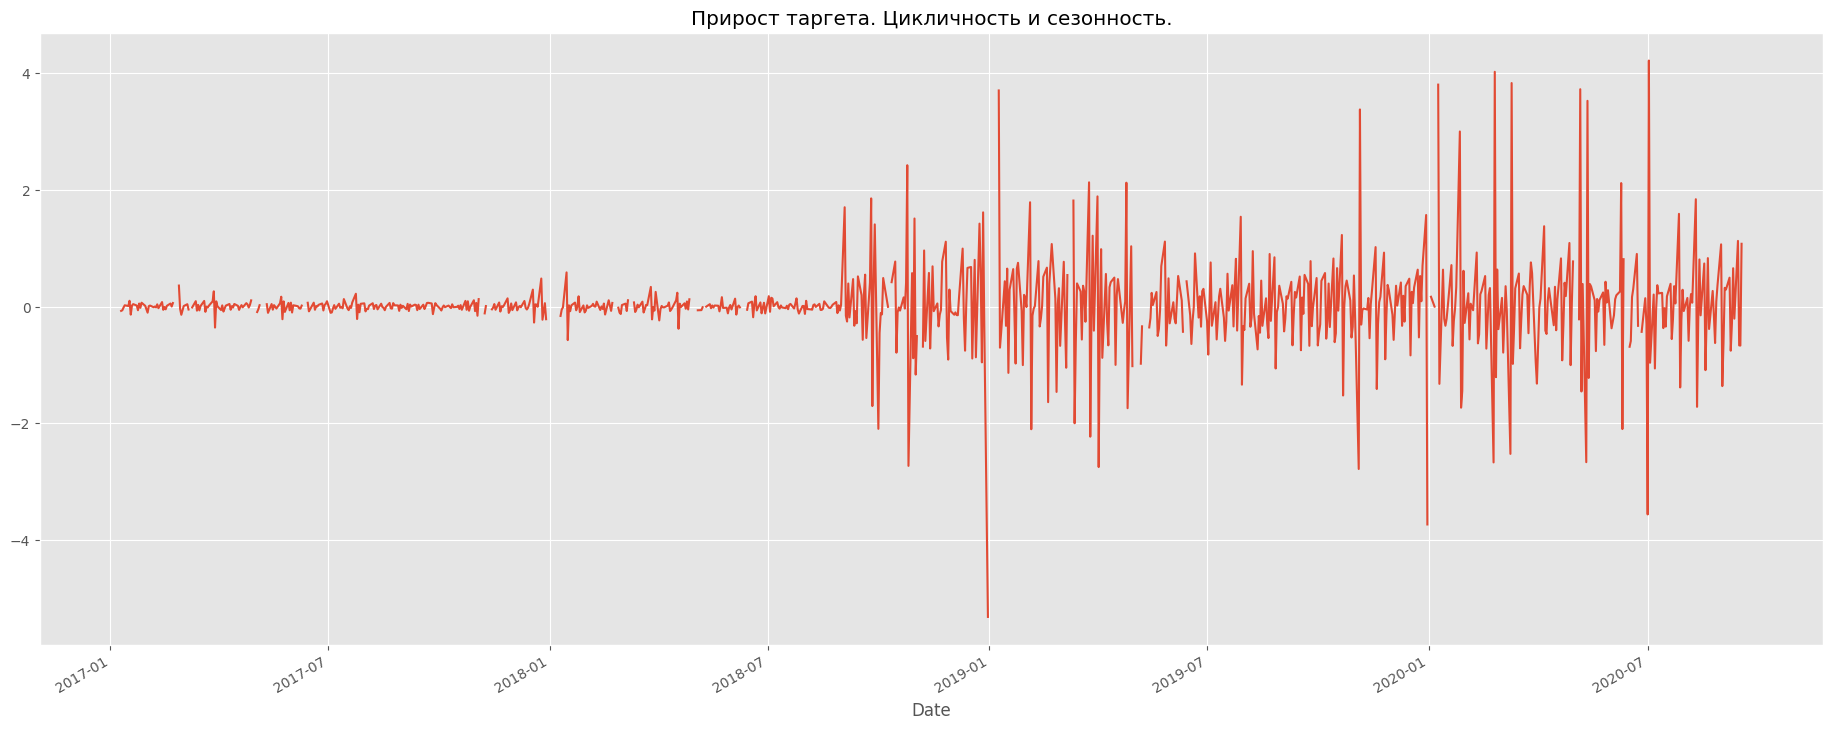

In [448]:
df.loc[:,'Target'].diff().plot() #что-то не то явно
plt.title('Прирост таргета. Цикличность и сезонность.');

## 3) Генерация признаков (3 балла)
Во временных рядах очень важно избегать утечек в данных (data leak). Их легко допуситть при неаккуратной генерации признаков. Например, если вы для прогноза $y_t$ будете исплользовать фичу разности $y_t - y_{t-1}$. Будьте осторожны и внимательны.

**Внимание!** При наличии хотя бы одной утечки в данном блоке стоимость всех пунктов делится на 2, кроме бонусного. Итого максимальный балл при наличии утечек равен 1.5 (или 2.5 при сделанном бонусе).


Создайте следующие признаки. Не забудьте лагировать необходимые фичи. Календарные фичи утечками не являются и могут даже заглядывать в будущее. Фичи с утечками не засчитываются. Выбор каждой фичи необходимо обосновать. Фичи без обоснования не засчитываются.

1) (0.75 балла) Календарные фичи. Придумайте не менее пяти фичей из календаря. Выбор каждой обоснуйте.

2) (0.15 балла) Структурный сдвиг. В середине ряда явно есть структурное изменение. Попробуйте придумать фичу, которая бы помогла это учесть.

3) (1 балл) Бонус! Одна из важных календарных фичей наряду с праздниками -- налоговые (бухгалтерские) дни. Найти их в удобном для чтения формате весьма проблемно, придётся парсить, но это весьма сильная фича. Код парсинга (или описание того, как вы их выкачивали) необходимо приложить, иначе пункт не засчитывается.

4) (0.1 балла) Лаги таргета.  (до 5 разных). Выбор каждого лага обоснуйте.

5) Экзогенные фичи (по 0.5 балла каждый пункт):
<ul>
<li>Значение ключевой ставки. Можно поискать на сайте ЦБ</li>
<li>Обменнык курс доллара. Тоже есть на сайте ЦБ либо в любом другом источнике. Например. YahooFinance</li>
<li>Спред ставок MosЗrime, все 7 показателей. Ставка MosPrime -- ставка кредитования в рублях на межбанковском рынке России. Спред -- разница между ставками кредита и депозита. У mosprime есть свой сайт.</li>
</ul>

6) Придумайте сами 2 фичи, которые считаете необходимыми (по 0.25 за каждую). Выбор каждой фичи обоснуйте.

In [449]:
ex_rates=pd.read_csv('exch_rates.csv') #курс доллара
ex_rates['Date'] = pd.to_datetime(ex_rates['Date'])
ex_rates.set_index('Date', inplace=True)
ex_rates['exc_rate']= (ex_rates.High + ex_rates.Low)/2
df = pd.merge(ex_rates, df, left_index=True, right_index=True, how='right').iloc[:,-2:]

df['structual_shift'] = df.index.map(lambda x: 1 if x > pd.to_datetime('2018-08-31') else 0) #структурный сдвиг

#Борис Борисович и Матвей в чате написали, что бухгалтерские дни можно занести в эксель табличку и использовать
#поэтому бонус не парсила, а собрала ручками с сайта https://www.b-kontur.ru/calendar/2017 по всем нужным годам (выбрав задачи "налоговые и бухгалтерские" на сайте)
#банки - юрлица, поэтому дни у них те же, что у обычных юрлиц (по крайней мере в 2017-2020)
report_dates = pd.read_csv('report_calendar.csv')
report_dates['Date'] = pd.to_datetime(report_dates['Date'])
df.index = pd.to_datetime(df.index)
df['reporting_days'] = df.index.isin(report_dates['Date']).astype(int)

mosprime_df = pd.read_csv('mosprime_rate.csv') #все 7 показателей моспрайма
mosprime_df['Date'] = pd.to_datetime(mosprime_df['Date'])
mosprime_df.set_index('Date', inplace=True)
mosprime_df.sort_index(inplace=True)
for column in mosprime_df.columns:
    mosprime_df[column] = mosprime_df[column].astype(str).str.replace(',', '.')
df = pd.merge(mosprime_df, df, left_index=True, right_index=True, how='right')

df.head()

,ON,1W,2W,1M,2M,3M,6M,exc_rate,Target,structual_shift,reporting_days
Date,,,,,,,,,,,
2017-01-09,8.93,9.04,9.08,9.12,9.11,9.12,9,59.763300,-0.082742,0,0
2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.962351,-0.154609,0,0
2017-01-11,8.33,8.32,8.31,8.35,8.37,8.38,8.35,60.317499,-0.216529,0,0
2017-01-12,8.4,8.39,8.39,8.38,8.36,8.36,8.36,59.425998,-0.231265,0,0
2017-01-13,10.27,10.4,10.45,10.51,10.58,10.59,10.59,59.498199,-0.207156,0,0


In [450]:
intervals = [pd.to_datetime('2017-03-26'), pd.to_datetime('2017-05-01'), pd.to_datetime('2017-06-18'), # https://base.garant.ru/10180094/
             pd.to_datetime('2017-09-17'), pd.to_datetime('2017-10-29'), pd.to_datetime('2017-12-17'), #значение ключевой ставки
             pd.to_datetime('2018-02-11'), pd.to_datetime('2018-03-25'), pd.to_datetime('2018-09-16'),
             pd.to_datetime('2018-12-16'), pd.to_datetime('2019-06-16'), pd.to_datetime('2019-07-28'),
             pd.to_datetime('2019-09-08'), pd.to_datetime('2019-10-27'), pd.to_datetime('2019-12-15'),
             pd.to_datetime('2020-02-09'), pd.to_datetime('2020-04-26'), pd.to_datetime('2020-06-21'),
             pd.to_datetime('2020-07-26'), pd.to_datetime('2021-03-21')]
values = [10, 9.75, 9.25, 9, 8.5, 8.25, 7.75, 7.5, 7.25, 7.5, 7.75, 7.5, 7.25, 7, 6.5, 6.25, 6, 5.5, 4.5, 4.25]

conditions = [df.index <= date for date in intervals]
df['key_rate'] = np.select(conditions, values, default=0)
df.head()

,ON,1W,2W,1M,2M,3M,6M,exc_rate,Target,structual_shift,reporting_days,key_rate
Date,,,,,,,,,,,,
2017-01-09,8.93,9.04,9.08,9.12,9.11,9.12,9,59.763300,-0.082742,0,0,10.0
2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.962351,-0.154609,0,0,10.0
2017-01-11,8.33,8.32,8.31,8.35,8.37,8.38,8.35,60.317499,-0.216529,0,0,10.0
2017-01-12,8.4,8.39,8.39,8.38,8.36,8.36,8.36,59.425998,-0.231265,0,0,10.0
2017-01-13,10.27,10.4,10.45,10.51,10.58,10.59,10.59,59.498199,-0.207156,0,0,10.0


In [451]:
import holidays
rus_holidays = holidays.Russia()
df['quarter']=df.index.quarter #учет кварталов поможет модели улавливать сезонность, связанную с изменениями в течение года
df['num_of_day']=df.index.day #признак может помочь учесть динамику изменений в течение месяца: например, наличие платежей в конце месяца или повышенная активность в начале месяца
df['num_of_month']=df.index.month #может быть полезен для моделирования сезонных изменений, а также для учета праздников и событий
df['num_of_year']=df.index.year # позволяет учитывать долгосрочные тренды и изменения во времени
df['Holiday'] = np.vectorize(lambda x: 1 if x in rus_holidays else 0)(df.index.date) # праздники существенно влияют на поведение временного ряда, в эти дни изменяется обычная активность и спрос
df['num_of_dayinweek']=(df.index.day_name()) #помогает учитывать различия в поведении данных в разные дни недели (учитывает недельную динамику изменений)
df['num_of_week_in_a_year'] = df.index.map(lambda x: x.isocalendar()[1])  #может помочь учесть сезонность, связанную с номером недели в году
df.head()

,ON,1W,2W,1M,2M,3M,6M,exc_rate,Target,structual_shift,reporting_days,key_rate,quarter,num_of_day,num_of_month,num_of_year,Holiday,num_of_dayinweek,num_of_week_in_a_year
Date,,,,,,,,,,,,,,,,,,,
2017-01-09,8.93,9.04,9.08,9.12,9.11,9.12,9,59.763300,-0.082742,0,0,10.0,1,9,1,2017,0,Monday,2
2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.962351,-0.154609,0,0,10.0,1,10,1,2017,0,Tuesday,2
2017-01-11,8.33,8.32,8.31,8.35,8.37,8.38,8.35,60.317499,-0.216529,0,0,10.0,1,11,1,2017,0,Wednesday,2
2017-01-12,8.4,8.39,8.39,8.38,8.36,8.36,8.36,59.425998,-0.231265,0,0,10.0,1,12,1,2017,0,Thursday,2
2017-01-13,10.27,10.4,10.45,10.51,10.58,10.59,10.59,59.498199,-0.207156,0,0,10.0,1,13,1,2017,0,Friday,2


Мною были выбраны допфичи - индекс Мосбиржи и цена на золото:
индекс Мосбиржи и цены на нефть являются важными экономическими индикаторами, которые могут отражать общее состояние экономики. Изменения в этих показателях могут влиять на финансовые потоки в банке.  Например, снижение цен на нефть может отразиться на курсах валют и финансовых рынках, влияя на поступления в банк. Использование таких внешних факторов в модели прогнозирования может улучшить точность прогнозов, так как они могут содержать информацию о будущих изменениях в сальдо поступлений, которая не учтена внутренними данными банка. Мониторинг индекса Мосбиржи и цен на нефть может помочь банку в управлении рисками, так как изменения в этих показателях могут сигнализировать о возможных финансовых трудностях или возможностях для банка.


In [452]:
imoex_df=pd.read_csv('imoex.csv')
imoex_df['Date'] = pd.to_datetime(imoex_df['Date'])
imoex_df.set_index('Date', inplace=True)
imoex_df.IMOEX = imoex_df.IMOEX.astype(str).str.replace(',', '.')
imoex_df.IMOEX = imoex_df.IMOEX.astype(str).str.replace(' ', '')
df = pd.merge(imoex_df, df, left_index=True, right_index=True, how='right')

gold_df=pd.read_csv('gold_price.csv')
gold_df['Date'] = pd.to_datetime(gold_df['Date'])
gold_df.set_index('Date', inplace=True)
gold_df.Gold = gold_df.Gold.astype(str).str.replace(',', '.')
df = pd.merge(gold_df, df, left_index=True, right_index=True, how='right')
df.head()

,Gold,IMOEX,ON,1W,2W,1M,2M,3M,6M,exc_rate,...,structual_shift,reporting_days,key_rate,quarter,num_of_day,num_of_month,num_of_year,Holiday,num_of_dayinweek,num_of_week_in_a_year
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-09,2457.88,2211.25,8.93,9.04,9.08,9.12,9.11,9.12,9,59.763300,...,0,0,10.0,1,9,1,2017,0,Monday,2
2017-01-10,NaN,2237.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.962351,...,0,0,10.0,1,10,1,2017,0,Tuesday,2
2017-01-11,2381.26,2218.61,8.33,8.32,8.31,8.35,8.37,8.38,8.35,60.317499,...,0,0,10.0,1,11,1,2017,0,Wednesday,2
2017-01-12,2414.85,2212.00,8.4,8.39,8.39,8.38,8.36,8.36,8.36,59.425998,...,0,0,10.0,1,12,1,2017,0,Thursday,2
2017-01-13,2308.2,2195.19,10.27,10.4,10.45,10.51,10.58,10.59,10.59,59.498199,...,0,0,10.0,1,13,1,2017,0,Friday,2


In [453]:
cols_to_convert = df.select_dtypes(include='object').columns.difference(['num_of_dayinweek'])

# преобразовываем все столбцы, кроме 'num_of_dayinweek', в числовой формат
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

df_numeric = df.select_dtypes(include='number')
df_filled = df_numeric.apply(lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean()))
df[df_filled.columns] = df_filled
df = df.fillna(method='ffill')


In [454]:
df['lag_1'] = df['Target'].shift(1) #лаги
df['lag_2'] = df['Target'].shift(2)
df['lag_3'] = df['Target'].shift(3)
df['lag_4'] = df['Target'].shift(4)
df['lag_5'] = df['Target'].shift(5)
df=df.iloc[5:,:] #удаляем первые пять строк, где неизвестный значения некоторых лагов, ибо непонятно как их заполнять и будет ли это корректно вообще


## 4) Одношаговое прогнозирование (1 балл)

Внимание! Запрещается пользоваться функцией make_reduction из sktime. Пункты Регрессия и Бенчмарк не будут засчитаны!

#### 4.1) Предобработка (0.3 балла)

Разбейте полученные данные на трейн и тест по времени. Размер теста: 0.2. Если необходимо, отнормируйте данные. Если необходимо, закодируйте категориальные фичи любым валидным методом.

In [455]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from sktime.utils.plotting import plot_series


In [456]:
y=df.Target
X=df.drop(['Target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train=y_train.sort_index(ascending=True) #на сколько я поняла из обсуждения в чате, для наивного прогноза надо брать последний объект по времени из трейна, поэтому сортируем по времени
X_train=X_train.sort_index(ascending=True)
numeric_features = X.select_dtypes([np.number]).columns
cat_features = X.select_dtypes('object').columns
X_train[numeric_features] = X_train[numeric_features].astype(float)
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

#### 4.2) Регрессия (0.3 балла)

Выберите ваш любимый регрессор и решите задачу одношагового прогнозирования. При необходимости подберите гиперпараметры. Кросс-валидацию мы ещё пройти не успели, поэтому можно отбирать параметры на тесте, держа в голове, что так делать не очень хорошо. Подсчитайте качество одношаговых прогнозов. В качестве метрики используйте WAPE.

$$WAPE=\frac{\sum_{t=1}^n\left|A_t-F_t\right|}{\sum_{t=1}^n\left|A_t\right|}, \quad A_t - Actual, F_t - Forecast$$

In [457]:
lr_pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('regressor', LinearRegression())
])
model = lr_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [458]:
# Вычисляем WAPE
def wape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

wape_score = wape(y_test, y_pred)
print("WAPE:", wape_score)

WAPE: 92.371995864097


#### 4.3) Бенчмарк (0.3 балла)

Постройте прогноз с помощью наивной модели. Наивная модель в качестве прогноза возвращает последнее доступное на текущий момент значение из трейна. Подсчитайте качество такого прогноза и сравните с вашей моделью. Если вы всё сделали правильно, то должно получиться как минимум не хуже. С налоговыми датами почти наверное получится лучше.




In [459]:
naive_pred = y_train.iloc[-1]
wape_score = wape(y_test, naive_pred)
print("WAPE naive model:", wape_score)

WAPE naive model: 1221.4928040450413


#### 4.4) Визуализация (0.1 балла)

Визуализируйте на одном графике тестовые данные, прогноз вашей модели и прогноз наивной модели. Подпишите все оси.

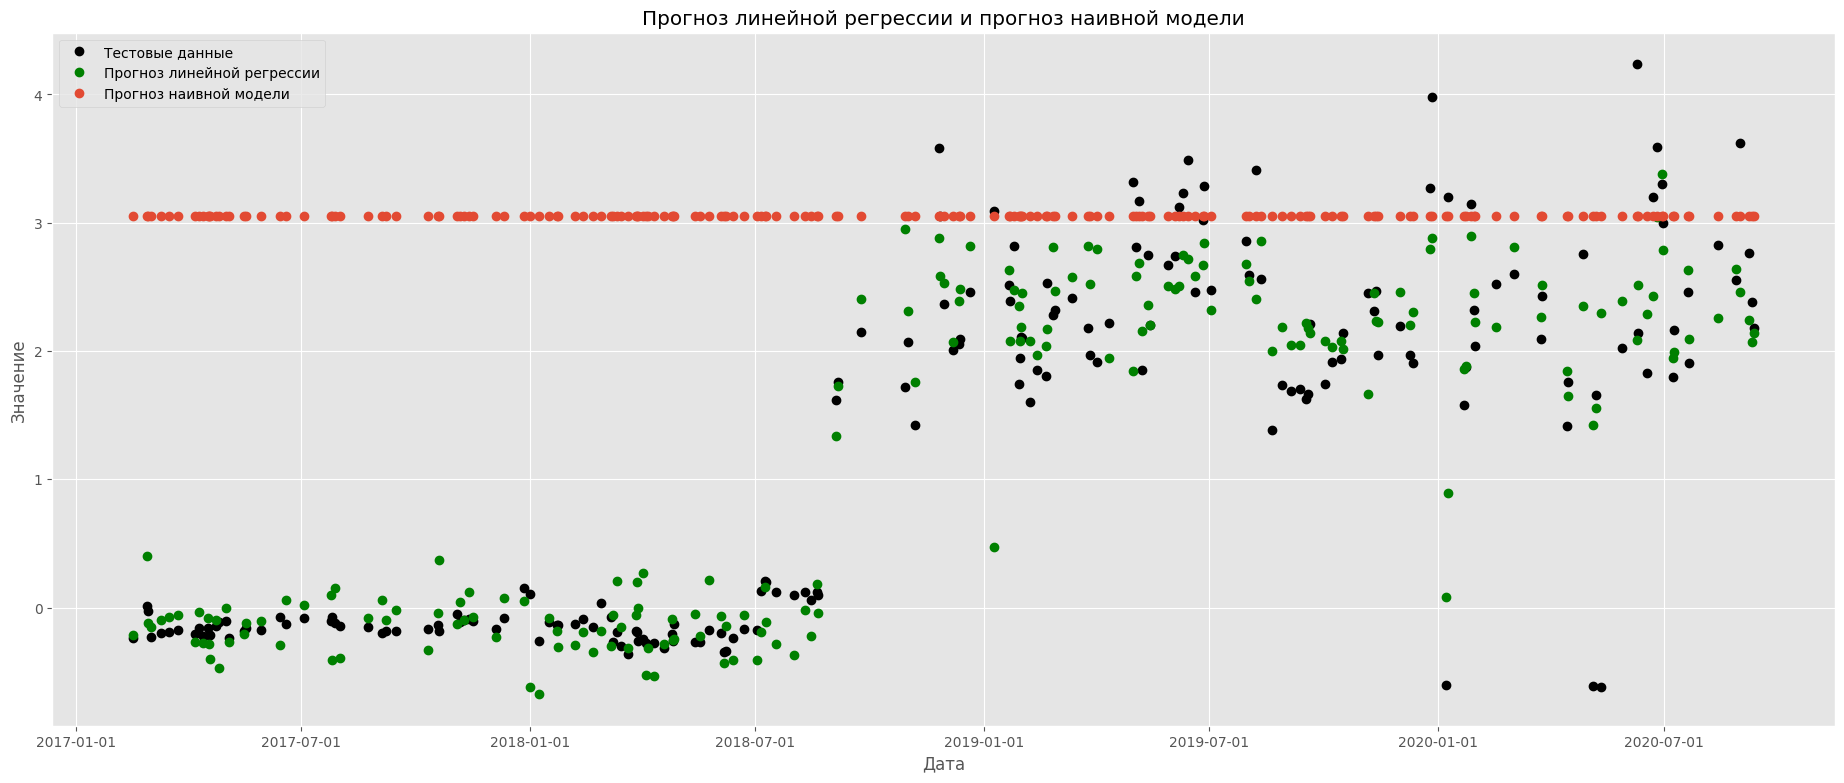

In [466]:
date_fmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_fmt)

plt.plot_date(y_test.index, y_test, label='Тестовые данные', color='black')
plt.plot_date(y_test.index, y_pred, label='Прогноз линейной регрессии', color='green')
plt.plot_date(y_test.index, [naive_pred] * len(y_pred), label='Прогноз наивной модели')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title('Прогноз линейной регрессии и прогноз наивной модели');

## 5) Многошаговое прогнозирование


Описание всех необходимых стратегий есть в [Конспекте](https://github.com/Pyatachokk/hse_ts_course/blob/master/2024-spring/seminars/sem_02_tables.pdf)

#### 5.1) Повтор препроцессинга (0 баллов)

Вернёмся к полному датасету. Повторите разбиение на трейн и тест. Возьмём в качестве теста последние 50 наблюдений. Соответственно, горизонт прогнозирования будет равен 50. Для упрощения задачи уберём все экзогенные переменные из датасета, которые нужно прогнозировать. Оставим только лаги таргета, календарные фичи и придуманные вами фичи если их не надо прогнозировать. Повторите нормирование и энкодинг, если делали их ранее и если это необходимо.

In [467]:
drop_features = ['Gold', 'IMOEX', 'ON', '1W', '2W', '1M', '2M', '3M', '6M', 'exc_rate']
X_train = df.drop(drop_features, axis=1).drop('Target', axis=1).iloc[:len(df) - 50]
y_train = df['Target'].iloc[:len(df) - 50]
X_test = df.drop(drop_features, axis=1).drop('Target', axis=1).iloc[len(df) - 50:]
y_test = df['Target'].iloc[len(df) - 50:]

categorical_features = ['num_of_dayinweek']
encoder = OneHotEncoder(sparse=False)
encoded_features_train = encoder.fit_transform(X_train[categorical_features].values.reshape(-1, 1))
encoded_features_test = encoder.transform(X_test[categorical_features].values.reshape(-1, 1))

scaler = StandardScaler()
numerical_features = [col for col in X_train.columns if col not in categorical_features]
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

X_train_encoded = np.hstack((X_train.drop(categorical_features, axis=1).values, encoded_features_train))
X_test_encoded = np.hstack((X_test.drop(categorical_features, axis=1).values, encoded_features_test))


#### 5.2) Рекурсивная стратегия (2 балла)

Внимание! Внимание! Запрещается пользоваться готовыми функциями. Рекурсивную стратегию необходимо написать вручную!

 Реализуйте рекурсивное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [468]:
model = LinearRegression()
model.fit(X_train_encoded, y_train)
predictions_rec = []
current_input = X_test_encoded[0].reshape(1, -1)
for _ in range(len(X_test_encoded)):
    next_pred = model.predict(current_input)
    current_input = np.roll(current_input, -1, axis=1)
    current_input[0, -1] = next_pred[0]
    predictions_rec.append(next_pred[0])
predictions_rec_df = pd.DataFrame(predictions_rec)

wape(y_test, predictions_rec)

134.91265834637898

#### 5.3) Прямая стратегия (1 балла)

Внимание! Запрещается пользоваться готовыми функциями. Прямую стратегию необходимо написать вручную!

Реализуйте прямое прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [469]:
predictions_dir = []
for x in X_test_encoded:
    next_pred = model.predict(x.reshape(1, -1))
    predictions_dir.append(next_pred[0])
predictions_dir[:5]
predictions_dir_df = pd.DataFrame(predictions_dir)

wape(y_test, predictions_dir)

12.549445614702359

#### 5.4) Стратегия DirRec (1.5 балла)

Внимание! Запрещается пользоваться готовыми функциями. Стратегию необходимо написать вручную!

Реализуйте смешанное прогнозирование на 50 шагов с помощью вашей любимой регрессионной модели.

In [470]:
predictions_mixed = []
X_train_mixed = X_train_encoded.copy()
y_train_mixed = y_train.copy()
model = LinearRegression()
for x in X_test_encoded:
    model.fit(X_train_mixed, y_train_mixed)
    next_pred = model.predict(x.reshape(1, -1))
    X_train_mixed = np.vstack((X_train_mixed, x))
    y_train_mixed = np.append(y_train_mixed, next_pred)
    predictions_mixed.append(next_pred[0])
predictions_mixed_df = pd.DataFrame(predictions_mixed)

wape(y_test, predictions_mixed)

12.549445614702364

#### 5.5) Результаты (0.5 балла)

Визуализируйте прогнозы стратегий и тестовые данные на одном графике. Подсчитайте WAPE прогнозов. Какая оказалась лучше? Как вы думаете, почему?

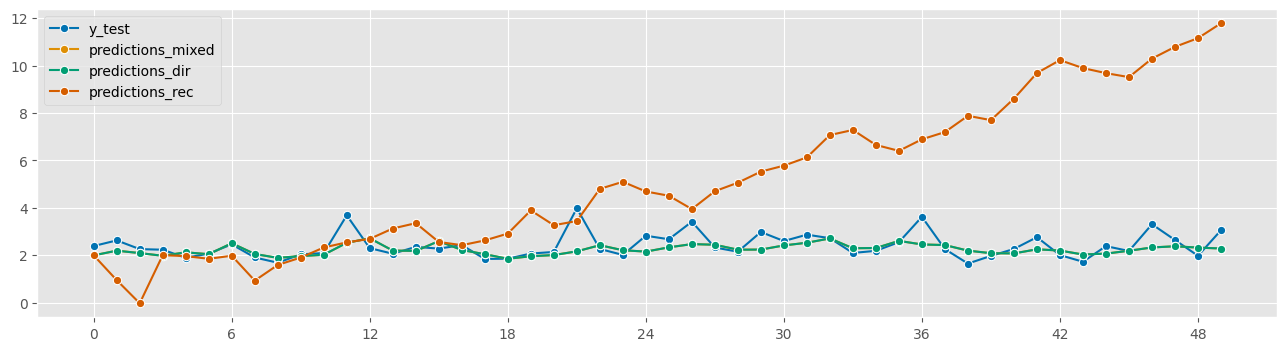

In [471]:
plot_series(y_test.to_frame().reset_index(drop=True), predictions_mixed_df, predictions_dir_df, predictions_rec_df,
            labels=['y_test',"predictions_mixed", "predictions_dir", "predictions_rec"]);


Получились почти идентичные результаты прямой и смешанной стратегий. Прямая стратегия делает прогнозы только на один шаг вперед (из конспекта: прямая стратегия очень неплохо работает вкупе с обычной линейной регрессией и при грамотно сгенерированных фичах - что я и увидела), не накапливая ошибку с предыдущих шагов, поэтому итоговое смещение модели меньше.  Возможно модель не смогла обнаружить значимых различий в прогнозах из-за ограниченности данных (мы срезали много признаков), поэтому результаты получились одинаковыми.

Рекурсивная стратегия показывает гораздо менее хорошие результаты из-за накапливающейся ошибки прогноза. Если первоначальный прогноз был неточным или содержал ошибку, она будет передаваться и накапливаться на каждом следующем шаге, что может привести к значительному искажению результатов. С каждым шагом ошибка предыдущего шага порождает ещё большу ошибку на последующих. Особенно сильно такой эффект наблюдается, когда модель имеет авторегрессию большего порядка.

##### Рубрика "как вам домашка?" (0.1 балла) -------- я прошла опросник




